In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *

### Diff in Diff Plot Function

In [2]:
def diff_in_diff_plot(df_treatment, df_control, policy_implementation_year, resp_variable, file_name):
    
    df_treatment['standardized_year'] = df_treatment['Year'] - policy_implementation_year
    df_control['standardized_year'] = df_control['Year'] - policy_implementation_year
    
    lower_lim = df_treatment['standardized_year'].min()
    upper_lim = df_treatment['standardized_year'].max()+1
    
    plot = (
        ggplot() +
        geom_smooth(df_treatment[df_treatment['standardized_year'] < 0], 
                    aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm') + 
        geom_smooth(df_treatment[df_treatment['standardized_year'] >= 0], 
                    aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm') + 

        geom_smooth(df_control[df_control['standardized_year'] < 0], 
                    aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm') + 
        geom_smooth(df_control[df_control['standardized_year'] >= 0], 
                    aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm')
        + geom_vline(xintercept = 0) 
        + xlab('Years before/after Policy Implementation Year: '+str(policy_implementation_year) 
        + '. \nRepresented as "0" on the x-axis.') 
        + ylab(str('Unemployment Rate') + ' \n(Adding 95% confidence interval)')
        + scale_x_continuous(breaks=range(lower_lim,upper_lim,1))
        + labs(title=str("Difference in Difference Plot "))

    )
    
    # Save plot to images folder.
    ggsave(filename=str('../20_Transformed_Source_Data/images/'+file_name),
           plot=plot,
           dpi=150,
           height=8,
           width=8,
           verbose = False)

    
    return plot


### Pre-Post Plot Function

In [3]:
def pre_post_plot(df_treatment, policy_implementation_year, resp_variable, file_name):
    df_treatment['standardized_year'] = df_treatment['Year'] - policy_implementation_year
    lower_lim = df_treatment['standardized_year'].min()
    upper_lim = df_treatment['standardized_year'].max()+1
    plot = (
    ggplot() +
    geom_smooth(df_treatment[df_treatment['standardized_year'] < 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm') + 
    geom_smooth(df_treatment[df_treatment['standardized_year'] >= 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment'), method='lm')
    + geom_vline(xintercept = 0) 
    + xlab('Years before/after Policy Implementation Year: '+str(policy_implementation_year) 
    + '. \nRepresented as "0" on the x-axis.') 
    + ylab(str(resp_variable) + ' \n(Adding 95% confidence interval)')
    + scale_x_continuous(breaks=range(lower_lim,upper_lim,1))
    + labs(title=str("Pre Post Plot"))
    )
    # Save plot to images folder.
    ggsave(filename=str('../20_Transformed_Source_Data/images/pre_post_'+file_name),
           plot=plot,
           dpi=150,
           height=8,
           width=8,
           verbose = False)
    return plot

### Load dataset

In [4]:
df = pd.read_csv('../20_Transformed_Source_Data/final_dataset.csv')
df = df.drop('Unnamed: 0', axis=1)
df['treatment'] = pd.Categorical(df['treatment'])

plot_df_treated = df[df['treatment'] == 1].copy()
plot_df_control = df[df['treatment'] == 0].copy()

### Pre-Post: Plot UnemploymentRate vs Time

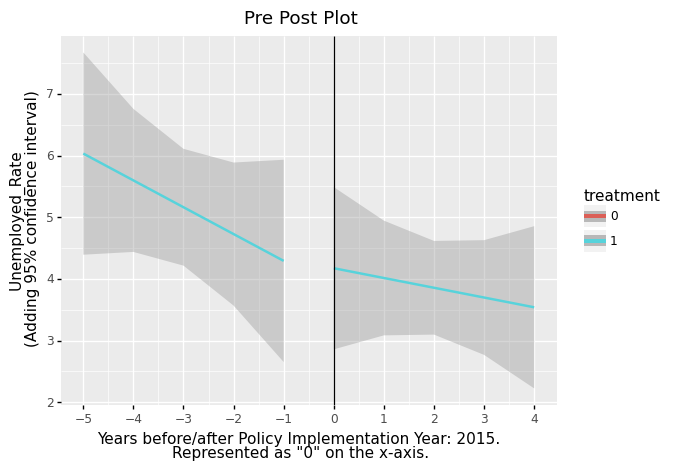

<ggplot: (8764023516389)>

In [5]:
# Min wages between treatment and control split in 2015.
policy_implementation_year = 2015
resp_variable = 'Unemployed_Rate'
file_name = 'UnemploymentRate_vs_Time_Pre_Post'
plot = pre_post_plot(plot_df_treated, policy_implementation_year, resp_variable, file_name)
plot

### Diff-in-diff: Plot UnemploymentRate vs Time

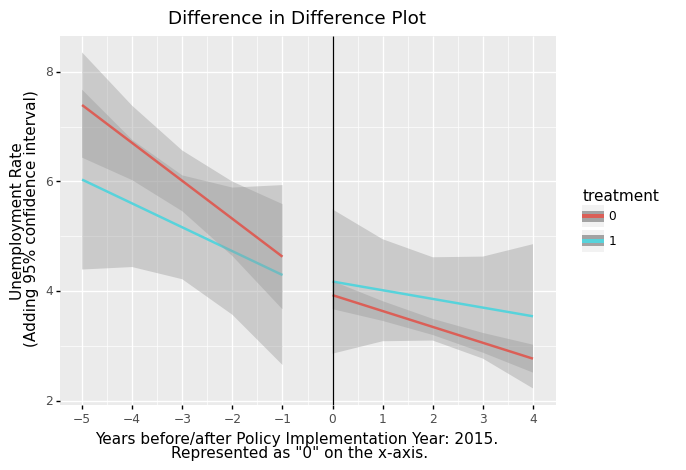

<ggplot: (8764012050460)>

In [6]:
# Min wages between treatment and control split in 2015.
policy_implementation_year = 2015
resp_variable = 'Unemployed_Rate'
file_name = 'UnemploymentRate_vs_Time'
plot = diff_in_diff_plot(plot_df_treated, plot_df_control, policy_implementation_year, resp_variable, file_name)
plot

### Difference in Difference Calculation

In [7]:
# Separate the treatement group into pre-treated and post-treated subsets

df_treated=df[df['treatment']==1]

pre_treated=df_treated.loc[df_treated['Year'].isin([2010,2011,2012,2013,2014]),['Unemployed_Rate','Year']]
post_treated=df_treated.loc[df_treated['Year'].isin([2016,2017,2018,2019]),['Unemployed_Rate','Year']]

# Calculate the mean value for the pre-treated subset

pre_treat_mean = np.mean(pre_treated['Unemployed_Rate'])
print(pre_treat_mean)

# Calculate the mean value for the post-treated subset

post_treat_mean = np.mean(post_treated['Unemployed_Rate'])
print(post_treat_mean)


5.1627777777777775
3.770138888888889


In [8]:
# Separate the control group into pre-treated and post-treated subsets

df_control=df[df['treatment']==0]

pre_control=df_control.loc[df_control['Year'].isin([2010,2011,2012,2013,2014]),['Unemployed_Rate','Year']]
post_control=df_control.loc[df_control['Year'].isin([2016,2017,2018,2019]),['Unemployed_Rate','Year']]

# Calculate the mean value for the pre-treated subset

pre_control_mean = np.mean(pre_control['Unemployed_Rate'])
print(pre_control_mean)

# Calculate the mean value for the post-treated subset

post_control_mean = np.mean(post_control['Unemployed_Rate'])
print(post_control_mean)


6.009444444444444
3.207638888888889


In [9]:
# Calculate the value for Difference in Difference

DD = (post_treat_mean - pre_treat_mean) - (post_control_mean - pre_control_mean)
print("DD", DD)

DD 1.4091666666666667


# Regression Analysis

### State Fixed Effects

In [10]:
#Add pre/post
pre = df[np.logical_and(df['Year'] >= 2010,df['Year'] <= 2014)].copy()
pre['Post'] = 0
post = df[np.logical_and(df['Year'] >= 2016,df['Year'] <= 2019)].copy()
post['Post'] = 1 

fe_df = pd.concat([pre, post])
fe_df.head()

,State,Year,FIPS_Code,Civilian_Pop,Civilian_Labor_Force,Labor_Force_Pct,Employed_Total,Employed_Pct,Unemployed_Total,Unemployed_Rate,Population,gdp,treatment,Post
0,Idaho,2010,16.0,1.165430e+06,762158.666667,65.408333,695375.583333,59.683333,66783.083333,8.758333,1570746.0,57952.9,0,0
1,Idaho,2011,16.0,1.179092e+06,764066.916667,64.800000,701595.750000,59.508333,62471.166667,8.166667,1583910.0,57825.3,0,0
2,Idaho,2012,16.0,1.193211e+06,772073.333333,64.708333,715011.583333,59.908333,57061.750000,7.400000,1595324.0,57780.1,0,0
3,Idaho,2013,16.0,1.208621e+06,777682.750000,64.350000,724710.750000,59.966667,52972.000000,6.816667,1611206.0,59966.8,0,0
4,Idaho,2014,16.0,1.226459e+06,777061.500000,63.358333,742988.166667,60.575000,34073.333333,4.383333,1631112.0,61663.2,0,0


In [11]:
model_fe = smf.ols('Unemployed_Rate ~ C(treatment) + C(Post) + C(treatment)*C(Post) + C(State) ', data=fe_df).fit()
model_fe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Unemployed_Rate   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     25.33
Date:                Wed, 30 Jun 2021   Prob (F-statistic):           8.76e-14
Time:                        20:20:01   Log-Likelihood:                -62.304
No. Observations:                  54   AIC:                             140.6
Df Residuals:                      46   BIC:                             156.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          6.5712      0.312     21.075      0.000       5.944       7.199
C(treatment)[T.1]                 -1.0563      0.284     -3.721      0.001      -1.628      -0.485
C(Post)[T.1]                      -2.8018      0.322     -8.704      0.000      -3.450      -2.154
C(State)[T.Iowa]                  -1.1278      0.392     -2.879      0.006      -1.916      -0.339
C(State)[T.Kansas]                -0.5574      0.392     -1.423      0.162      -1.346       0.231
C(State)[T.Nebraska]              -1.3691      0.245     -5.584      0.000      -1.863      -0.876
C(State)[T.South Dakota]          -1.2746      0.245     -5.198      0.000      -1.768      -0.781
C(State)[T.West Virginia]          1.5874      0.245      6.474      0.000       1.094       2.081
C(treatment)[T.1]:C(Post)[T.1]     1.4092      0.455      3.096      0.003       0.493       2.325
==============================================================================
Omnibus:                        2.523   Durbin-Watson:                   1.399
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                1.883
Skew:                           0.038   Prob(JB):                        0.390
Kurtosis:                       3.912   Cond. No.                     1.57e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.91e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""